# In this notebook I analyze 2008 Seattle AirBnb data from https://www.kaggle.com/datasets/airbnb/seattle/data.

### Additionally, I used Seattle poverty data data from https://data-seattlecitygis.opendata.arcgis.com/datasets/3ee2c37817454b9089e8c4d73a43c2f2_0/explore.





### Libraries

In [1]:
!pip install geopandas
!pip install descartes

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from google.colab import files

## Data cleaning

In [2]:
# Loading data
df_listings = pd.read_csv('listings.csv')
df_calendar = pd.read_csv('calendar.csv')
df_reviews = pd.read_csv('reviews.csv')

# Additional data from https://data-seattlecitygis.opendata.arcgis.com/search?collection=dataset
df_poverty = pd.read_csv('poverty_Neighborhoods_8347059163735153245.csv')

In [3]:
#df_listings.info()
#df_listings.describe()

In [4]:
#df_reviews.info()
#df_reviews.describe()

In [5]:
#df_calendar.info()
#df_calendar.describe()

In [6]:
# Creating additional columns
df_listings['host_since'] = pd.to_datetime(df_listings['host_since'])
df_listings['calendar_last_scraped'] = pd.to_datetime(df_listings['calendar_last_scraped'])
df_listings['time_diff'] = (df_listings['calendar_last_scraped'] - df_listings['host_since']).dt.days
df_listings['Years since registration'] = df_listings['time_diff'] / 365.25
df_listings['neighbourhood'] = df_listings['neighbourhood'].fillna('None')
df_calendar['month'] = pd.to_datetime(df_calendar['date']).dt.month_name()
df_calendar['day_of_month'] = pd.to_datetime(df_calendar['date']).dt.day
df_calendar['day_of_week'] = pd.to_datetime(df_calendar['date']).dt.day_name()
df_reviews['cancelled_by_host'] = df_reviews['comments'].apply(lambda x: 1 if str(x).startswith('The host canceled this reservation') else 0)
df_reviews['cancelled_by_guest'] = df_reviews['comments'].apply(lambda x: 1 if str(x).startswith('The reservation was canceled') else 0)

# Calculating % Population 20 to 64 years below poverty in Seattle by neighborhoods
df_poverty['% Population 20 to 64 years below poverty'] = (df_poverty['Population 20 to 64 years below poverty'] / df_poverty['Population 20 to 64 years for whom poverty status is determined']) * 100

# Splitting neighborhood names where they are concatenated
new_rows = []

for index, row in df_poverty.iterrows():
  neighborhood_name = row['Neighborhood Name']
  if '/' in neighborhood_name:
    parts = neighborhood_name.split('/')

    new_row1 = row.copy()
    new_row1['Neighborhood Name'] = parts[0].strip()
    new_rows.append(new_row1)

    new_row2 = row.copy()
    new_row2['Neighborhood Name'] = parts[1].strip()
    new_rows.append(new_row2)
  else:
    new_rows.append(row)
df_poverty = pd.DataFrame(new_rows)

# Creating a mapping from Neighborhood Name to % Population 20 to 64 years below poverty
poverty_mapping = dict(zip(df_poverty['Neighborhood Name'], df_poverty['% Population 20 to 64 years below poverty']))

# Defining a function to find the matching poverty percentage for available neighborhoods
def get_poverty_percentage(neighb_group):
    for neighborhood, poverty_percentage in poverty_mapping.items():
        if neighb_group == neighborhood:
            return poverty_percentage
    return None

# Attempt to fill the poverty percentage column based on 'neighbourhood_group_cleansed'
df_listings['% Population 20 to 64 years below poverty in neighborhood'] = df_listings['neighbourhood_group_cleansed'].apply(get_poverty_percentage)

# Fill missing values using 'neighbourhood' and 'neighbourhood_cleansed' if still NaN
df_listings['% Population 20 to 64 years below poverty in neighborhood'] = df_listings['% Population 20 to 64 years below poverty in neighborhood'].fillna(
    df_listings['neighbourhood'].apply(get_poverty_percentage))

df_listings['% Population 20 to 64 years below poverty in neighborhood'] = df_listings['% Population 20 to 64 years below poverty in neighborhood'].fillna(
    df_listings['neighbourhood_cleansed'].apply(get_poverty_percentage))

# Deleting unneeded columns
df_listings = df_listings.drop(columns=['requires_license', 'has_availability', 'listing_url','host_neighbourhood', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'amenities', 'license', 'host_name', 'jurisdiction_names', 'host_location', 'host_verifications', 'street', 'market', 'smart_location', 'country_code', 'country', 'city', 'state'])

# Converting price column to numeric, handling potential errors
for col in ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']:
    df_listings[col] = pd.to_numeric(df_listings[col].str.replace('[$,]', '', regex=True), errors='coerce')

df_calendar['price'] = pd.to_numeric(df_calendar['price'].str.replace('[$,]', '', regex=True), errors='coerce')

## Data analysis

### Geospatial analysis

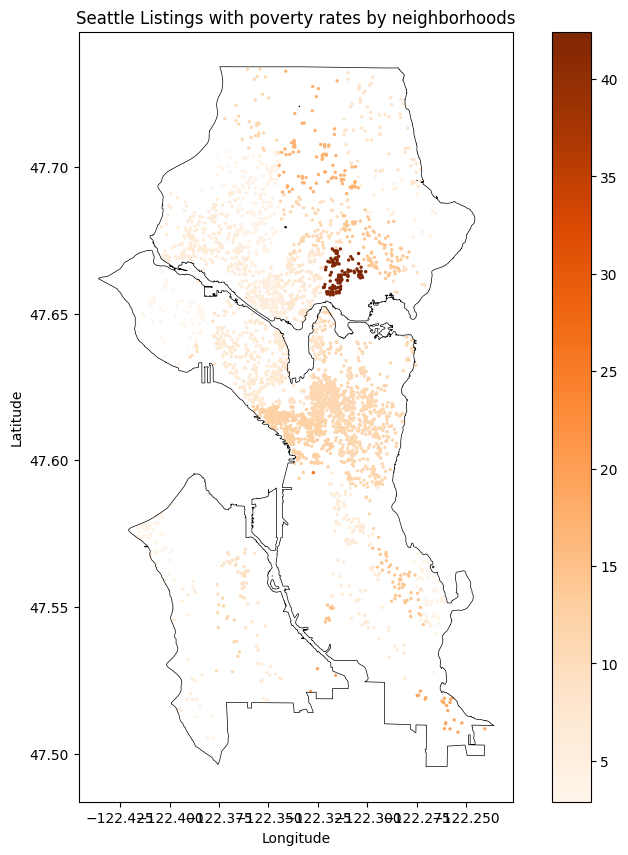

In [7]:
# Creating a GeoDataFrame of listings
geometry = gpd.points_from_xy(df_listings['longitude'], df_listings['latitude'])
gdf_listings = gpd.GeoDataFrame(df_listings, geometry=geometry)

# Creating the city boundaries outline using a geodata from https://github.com/seattleio/seattle-boundaries-data/blob/master/data/city-limits.geojson
seattle = gpd.read_file('city-limits.geojson').geometry

# Plotting data
fig, ax = plt.subplots(figsize=(10, 10))
gdf_listings.plot(ax=ax, column='% Population 20 to 64 years below poverty in neighborhood', legend=True, markersize=2, cmap='Oranges')
seattle.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

plt.title('Seattle Listings with poverty rates by neighborhoods')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Geospatial analysis can be used to determine potential risks for guests, such as natural disasters or crime.

I plotted listings according to their latitude and longitude and supplemented the data by official statistics on % of population between 20 to 64 years below poverty line. While poverty is not a 1 to 1 predictor of crime, poverty and crime are correlated somewhat. We can see that poverty rate is higher in neighborhoods located in the central, northern and southeastern Seattle. The part with unusually high poverty in central-northern part of Seattle is the University District, the poverty rate is high here because of a high number of students, who are generally poorer.

Airbnb can use such analysis to refuse listings from neighborhoods with especially high crime rates to prevent any negative experiences for guests and protect reputation and brand strength of the company.

Additionally, Airbnb can use geospatial analysis to inform guests and hosts or automatically cancel bookings in dangerous areas in case of natural disasters such as forest fires, floods or earthquakes.

### Pricing analysis

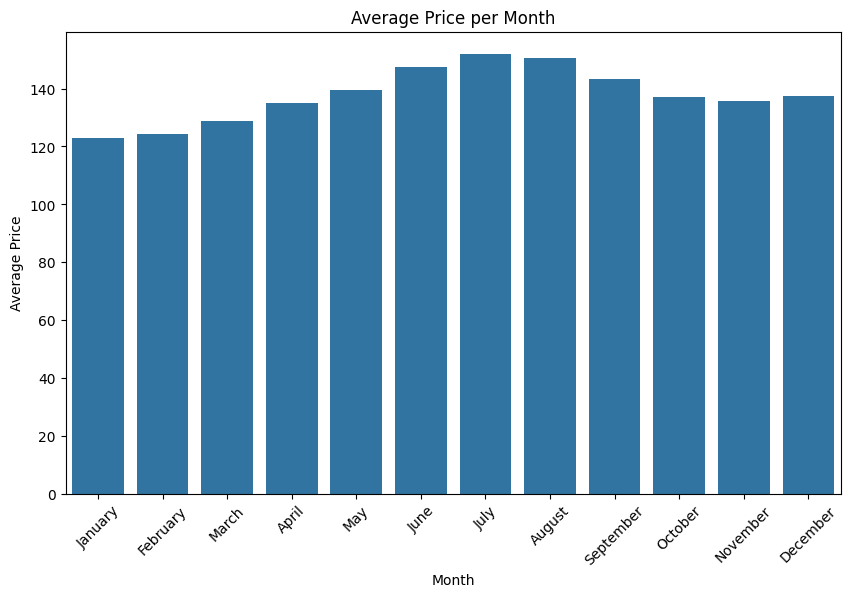

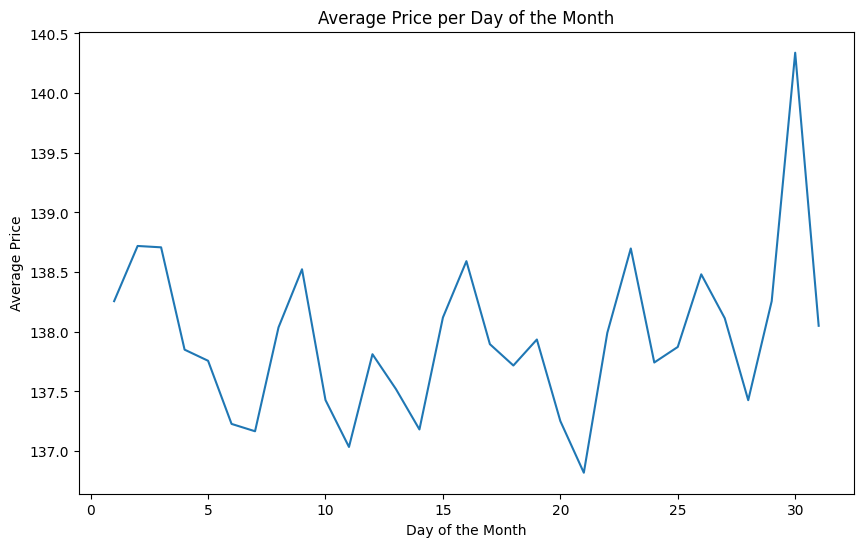

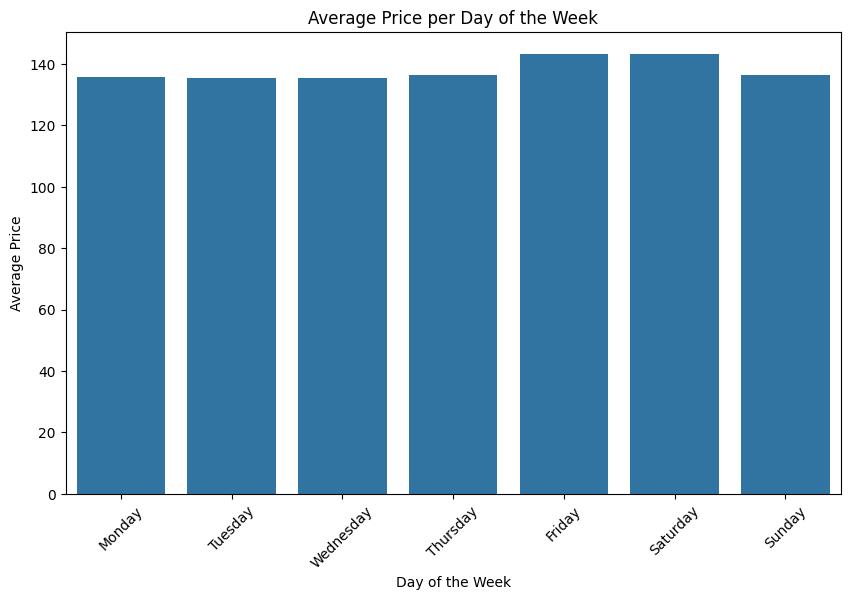

In [8]:
df_calendar_for_price = df_calendar[df_calendar['available'] != 'f']

avg_price_month = df_calendar_for_price.groupby('month')['price'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='price', data=avg_price_month, order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Average Price per Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

avg_price_day_of_month = df_calendar_for_price.groupby('day_of_month')['price'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='day_of_month', y='price', data=avg_price_day_of_month)
plt.title('Average Price per Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Average Price')
plt.show()

avg_price_day_of_week = df_calendar_for_price.groupby('day_of_week')['price'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='price', data=avg_price_day_of_week, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Average Price per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

Prices are a big part of experience on the platform for both parties. For both parties to be happy Airbnb needs to ensure prices are stable on the platform over time. The primary way Airbnb can work on price stability is by ensuring a balance between the demand and supply of listings.

Generally, prices are higher in Seattle during the summer months  and slightly higher on Fridays and Saturdays compared to the other days of the week. The difference in prices are due to higher demand and lower supply of listings during those periods.

Airbnb would benefit from incentivizing higher demand during the periods of lower prices and incentivizing supply during the periods of higher prices, for example, via marketing campaigns and/or commission and fee discounts.

### Review Score Analysis

In [9]:
df_review_scores = df_listings[['review_scores_rating']].copy()
df_review_scores_no_100 = df_review_scores[df_review_scores['review_scores_rating'] != 100]

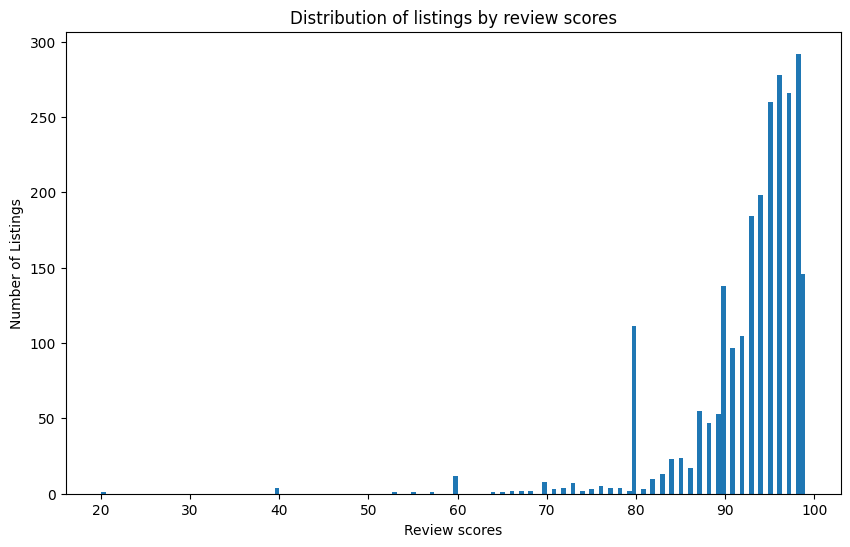

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(df_review_scores_no_100['review_scores_rating'].values, bins=150)
plt.xlabel('Review scores')
plt.ylabel('Number of Listings')
plt.title('Distribution of listings by review scores')
plt.show()

Review scores are a great metric to see how a particular listing is doing. The scores are a direct reflection of customer experience. Therefore, Airbnb should try influence hosts to improve their listings and achieve higher review scores.

In this analysis listings with a perfect review score of 100 have been dropped for better visualization. The number of listings with a review score of 100 = 781. Most listings have a score of above 90, however, there are plenty listings with lower scores too.

Airbnb would benefit from investigating the reasons for bad review by analyzing review comments or, by sending out guides on how to improve guest experience to hosts with bad reviews, or by financially penalizing hosts with poor reviews.

### Cancellation analysis

In [11]:
cancellations = df_reviews.groupby('listing_id').agg(
    cancelled_by_host_sum=('cancelled_by_host', 'sum'),
    cancelled_by_guest_sum=('cancelled_by_guest', 'sum')
).reset_index()

cancellations = cancellations.drop_duplicates()

In [12]:
cancellations_no_0 = cancellations[cancellations['cancelled_by_host_sum'] != 0]

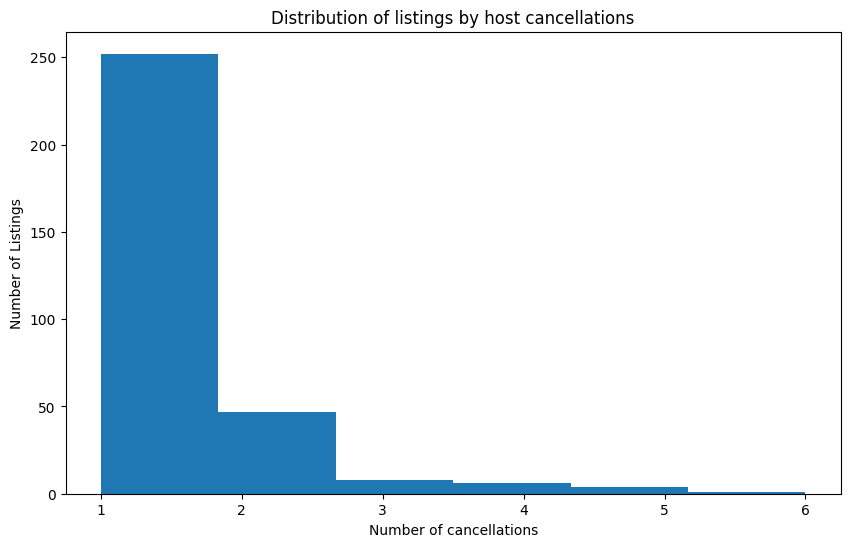

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(cancellations_no_0['cancelled_by_host_sum'].values, bins=6)
plt.xlabel('Number of cancellations')
plt.ylabel('Number of Listings')
plt.title('Distribution of listings by host cancellations')
plt.show()

Cancellations by hosts create a negative experience for guests and therefore should be minimized.

In this analysis listings with 0 cancellations have been dropped for better visualization. The number of listings with 0 cancellations = 2865. Most listings have 0-1 cancellations. However, there are a few which range from 2 to 6.

Airbnb would benefit from incentivizing hosts to cancel bookings less through financial means, for example by providing small discounts on commissions for not cancelling a booking in a long time or charging a penalty fee in case of cancellation.

In addition to giving out superhost designations Airbnb could reward hosts for not cancelling through nonfinancial means, for example by gamifying the experience and showing a streak of days with no cancellations or giving out achievements.

### Availability analysis

In [14]:
df_listings_no_365 = df_listings[df_listings['availability_365'] != 365]

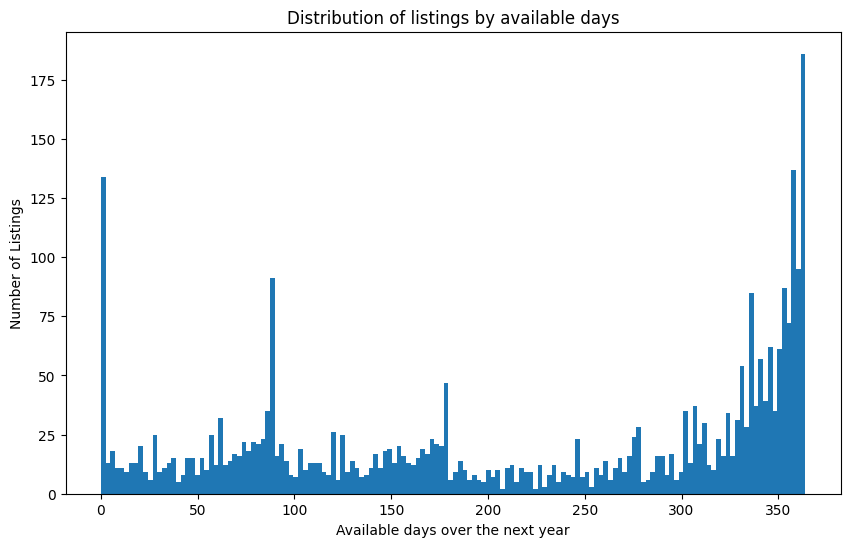

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(df_listings_no_365['availability_365'].values, bins=150)
plt.xlabel('Available days over the next year')
plt.ylabel('Number of Listings')
plt.title('Distribution of listings by available days')
plt.show()

Airbnb needs to drive availability to ensure there are plenty of options to browse for guests on the platform. Declining number of available listings on the platform would negatively impact customer experience.

In this analysis listings with 365 available days have been dropped for better visualization. The number of listings with 365 available days = 678. We can see that there are a lot listings with fewer than 300 available days over the next year.

Airbnb would benefit from trying to incentivize such hosts to make their listings available for more days and therefore increase the supply of listings on the platform. Airbnb can do that via reminder emails and app notifications as well as financial incentives.

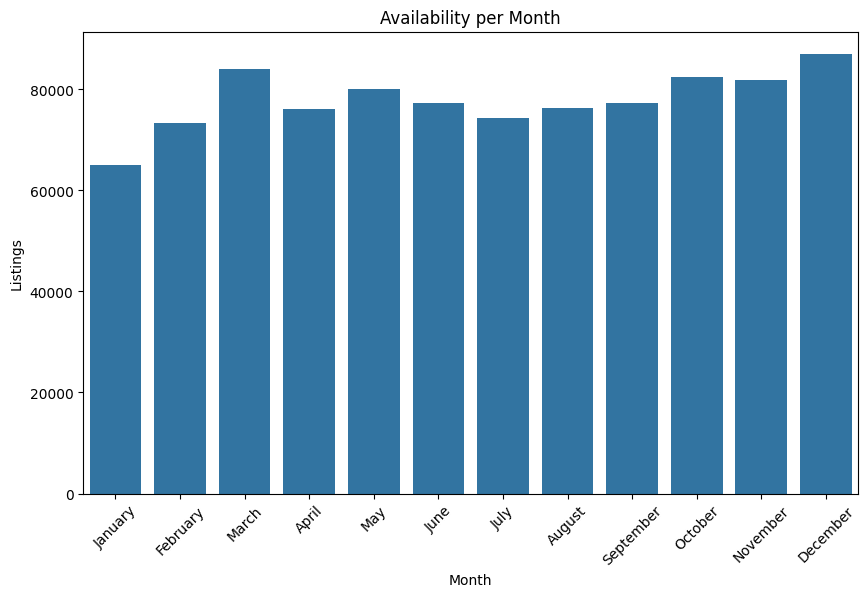

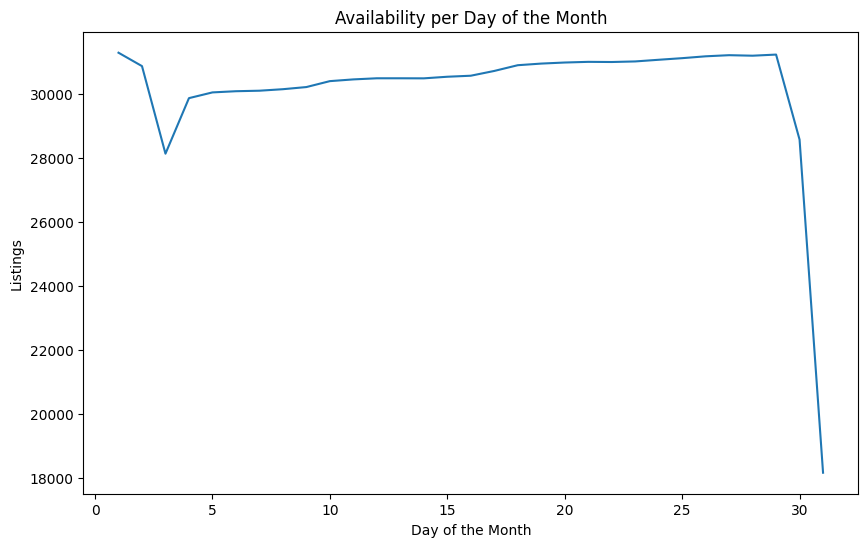

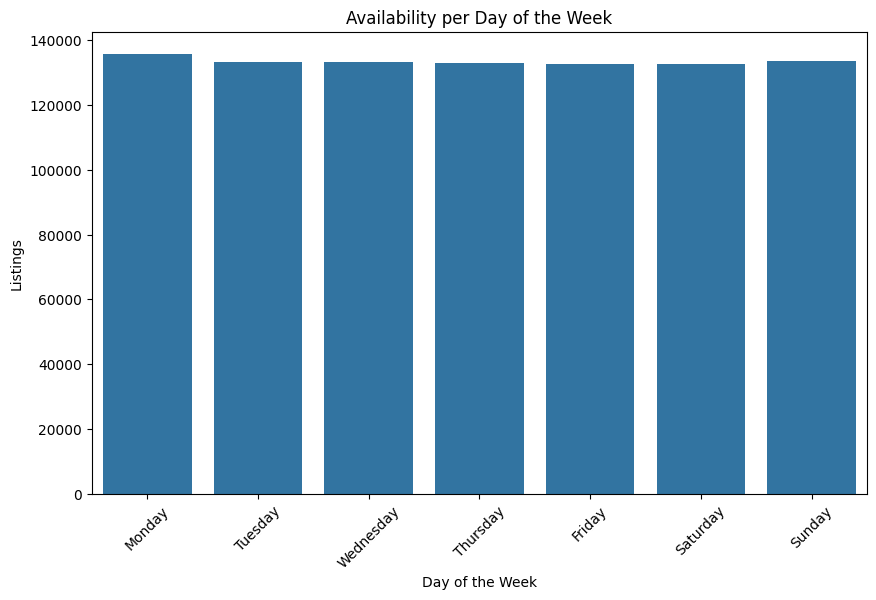

In [16]:
df_calendar_for_availability = df_calendar[df_calendar['available'] != 'f']
#df_calendar_for_availability.to_csv('df_calendar_for_availability.csv', index=False)

cnt_availability_month = df_calendar_for_availability.groupby('month')['price'].count().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='price', data=cnt_availability_month , order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Availability per Month')
plt.xlabel('Month')
plt.ylabel('Listings')
plt.xticks(rotation=45)
plt.show()

cnt_availability_day_of_month= df_calendar_for_availability.groupby('day_of_month')['price'].count().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='day_of_month', y='price', data=cnt_availability_day_of_month)
plt.title('Availability per Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Listings')
plt.show()

cnt_availability_day_of_week = df_calendar_for_availability.groupby('day_of_week')['price'].count().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='price', data=cnt_availability_day_of_week, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Availability per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Listings')
plt.xticks(rotation=45)
plt.show()

It is important to note that availability is lower in January and February because it does not account for listings that have been booked out. Overall, the is a decline in availability in the summer months.

While the reason for the summer decline needs to be investigated Airbnb would benefit from trying to incentivize hosts to put more listings onto the platform and therefore increase the supply of listings. Airbnb could potentially do that via  commission discounts or non-financial means.

### Important hosts and guests analysis

In [17]:
df_hosts = df_listings[['host_id', 'host_total_listings_count']].copy()

df_hosts = df_hosts.drop_duplicates()

df_hosts = df_hosts.sort_values('host_total_listings_count', ascending=False)

top_15_hosts = df_hosts.head(15)

top_15_hosts

,host_id,host_total_listings_count
1219,30283594,502.0
185,31148752,354.0
1065,4962900,169.0
1493,661691,163.0
1492,103427,84.0
1077,8534462,48.0
315,1243056,37.0
97,430709,36.0
498,74305,34.0
687,3074414,34.0


In [18]:
df_reviewers = df_reviews[['reviewer_id']].copy()

df_reviewers['count'] = df_reviewers.groupby('reviewer_id')['reviewer_id'].transform('count')

df_reviewers = df_reviewers.drop_duplicates()

df_reviewers = df_reviewers.sort_values('count', ascending=False)
top_15_reviewers = df_reviewers.head(15)

top_15_reviewers

,reviewer_id,count
2981,206203,67
939,15121499,32
838,2734499,19
7090,5775807,19
5922,29590276,18
20432,7448809,17
3223,8013961,16
4397,5053141,14
9719,1971733,14
292,41158892,14


I extracted top 15 lists of hosts by number of listings and of guests by number of reviews. The lists display particularly loyal hosts and guests.

Airbnb would benefit from doing its best to keep these happy, especially the hosts, since both, top hosts and active guests provide a lot of business.

It may be smart to assign personal well-trained partner host services specialists to the top hosts as well as providing them with special discounts to ensure they are happy.

Also, the active guests could be incentivized to use the platform and write reviews through discounts or non-financial rewards such as achievements and public acknowledgements.


### General analysis of data in columns

In [19]:
categorical_columns = ['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
                    'host_identity_verified', 'neighbourhood_group_cleansed',
                    'is_location_exact', 'property_type', 'room_type']

categorical_columns_2 = ['bed_type', 'calendar_updated', 'instant_bookable', 'cancellation_policy',
                         'require_guest_profile_picture', 'require_guest_phone_verification']

numerical_columns = ['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count',
                      'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet']

numerical_columns_2 = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
                      'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights']

numerical_columns_3 = ['availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews',
                      'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin']

numerical_columns_4 = ['review_scores_communication', 'review_scores_location', 'review_scores_value',
                      'calculated_host_listings_count', 'reviews_per_month']

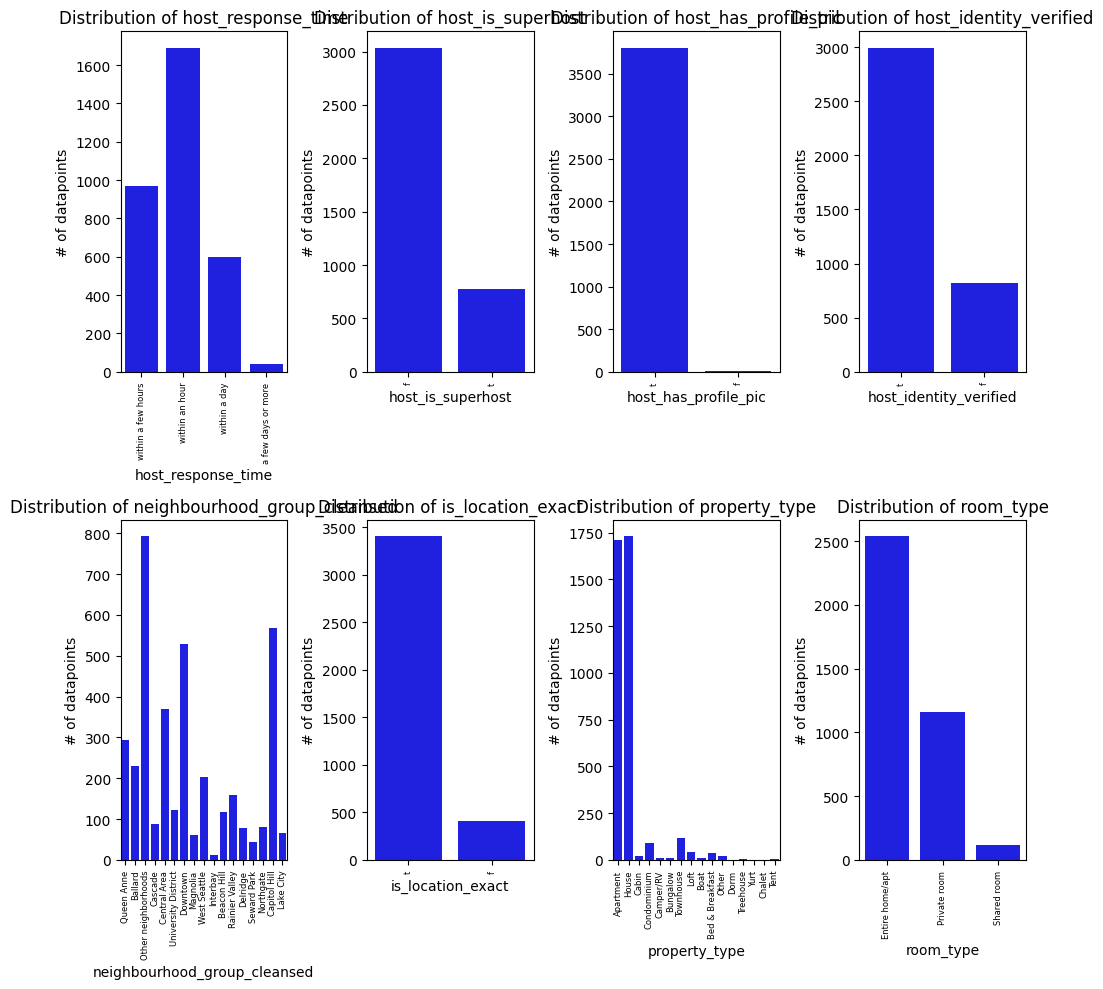

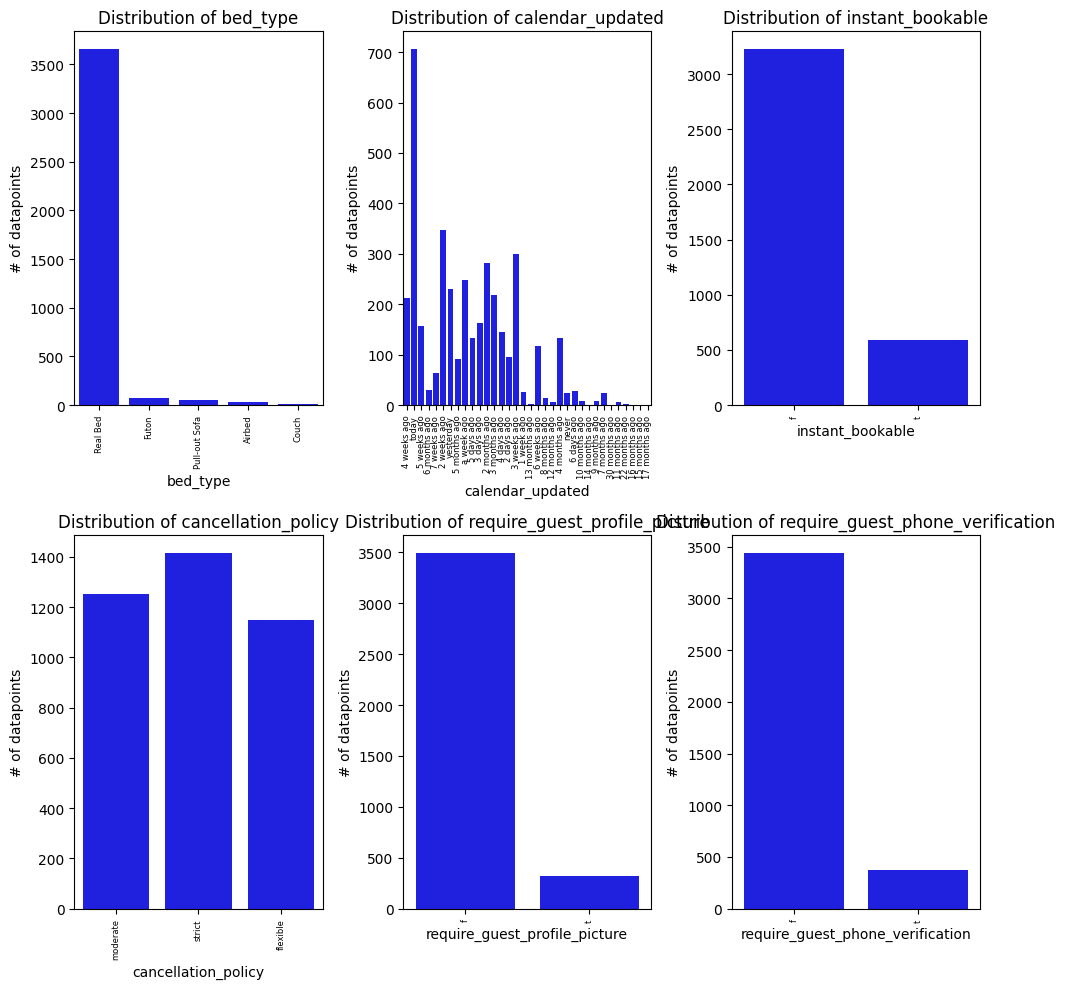

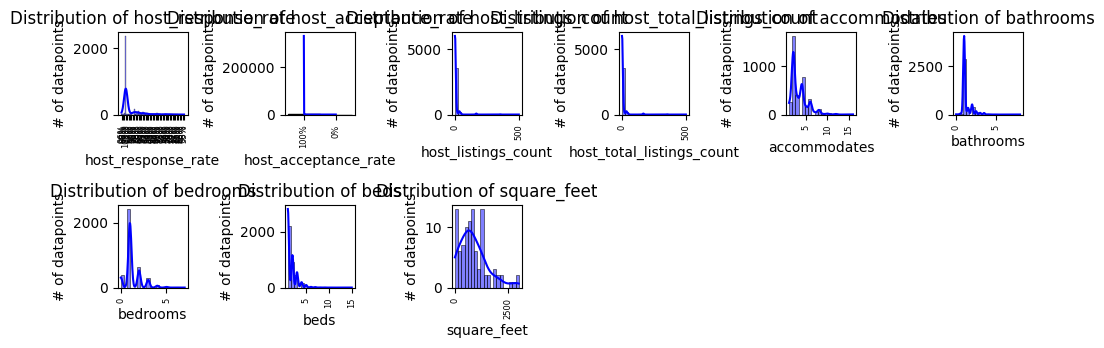

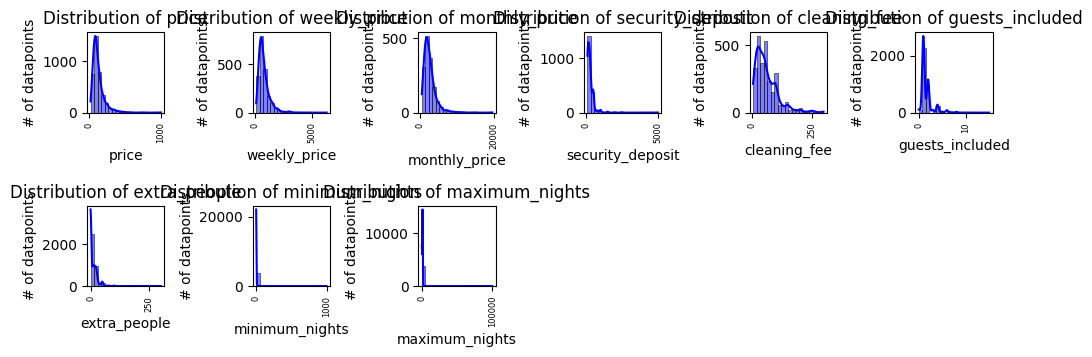

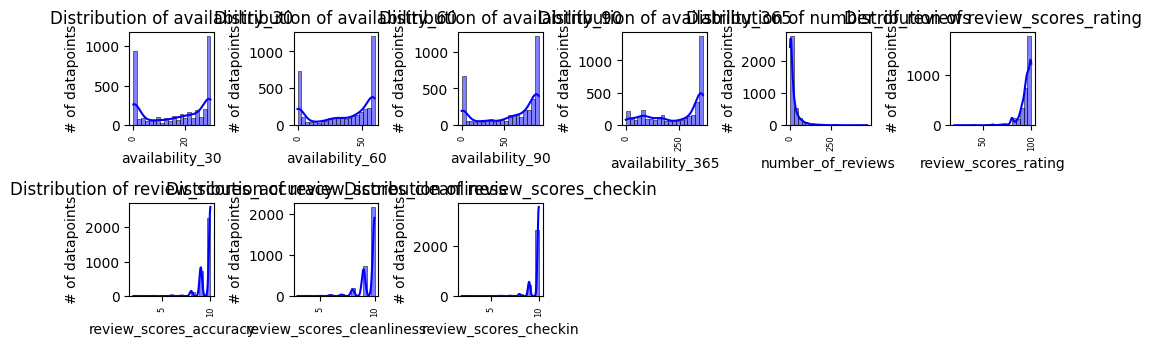

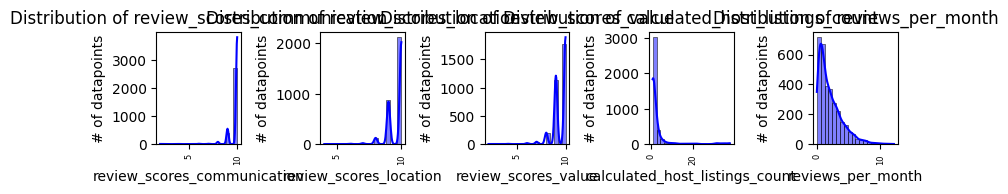

In [20]:
# Creating a matrix of distributions of categorical columns
plt.figure(figsize=(10, 10))
for i, column in enumerate(categorical_columns, start=1):
    plt.subplot(2, 4, i)
    sns.countplot(data=df_listings, x=column, color='blue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('# of datapoints')
    plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
for i, column in enumerate(categorical_columns_2, start=1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df_listings, x=column, color='blue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('# of datapoints')
    plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()


# Creating a matrix of distributions of numerical columns
plt.figure(figsize=(10, 10))
for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(6, 6, i)
    sns.histplot(data = df_listings[column], kde=True, color='blue', bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('# of datapoints')
    plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
for i, column in enumerate(numerical_columns_2, start=1):
    plt.subplot(6, 6, i)
    sns.histplot(data = df_listings[column], kde=True, color='blue', bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('# of datapoints')
    plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
for i, column in enumerate(numerical_columns_3, start=1):
    plt.subplot(6, 6, i)
    sns.histplot(data = df_listings[column], kde=True, color='blue', bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('# of datapoints')
    plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
for i, column in enumerate(numerical_columns_4, start=1):
    plt.subplot(6, 6, i)
    sns.histplot(data = df_listings[column], kde=True, color='blue', bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('# of datapoints')
    plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()

#sns.pairplot(df_listings[numerical_columns], corner=True, plot_kws={'alpha':0.2})